# Google Ventilator Feature Importance with LOFO

![](https://raw.githubusercontent.com/aerdem4/lofo-importance/master/docs/lofo_logo.png)

**LOFO** (Leave One Feature Out) Importance calculates the importances of a set of features based on **a metric of choice**, for **a model of choice**, by **iteratively removing each feature from the set**, and **evaluating the performance** of the model, with **a validation scheme of choice**, based on the chosen metric.

LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.

While other feature importance methods usually calculate how much a feature is used by the model, LOFO estimates how much a feature can make a difference by itself given that we have the other features. Here are some advantages of LOFO:
* It generalises well to unseen test sets since it uses a validation scheme.
* It is model agnostic.
* It gives negative importance to features that hurt performance upon inclusion.
* It can group the features. Especially useful for high dimensional features like TFIDF or OHE features. It is also good practice to group very correlated features to avoid misleading results.
* It can automatically group highly correlated features to avoid underestimating their importance.

https://github.com/aerdem4/lofo-importance

In [1]:
!pip install lofo-importance


You should consider upgrading via the 'c:\pythons\p376\python.exe -m pip install --upgrade pip' command.


In [36]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import os, sys
import torch

PATH = 'e:\\Krivenko\\Kaggle\\2021\\New20211005\\'


df = pd.read_csv(f"{PATH}/train.csv")
print(df.shape)
df.head()

(6036000, 8)


,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [37]:
def engineer_features(df):
    df["u_in_sum"] = df.groupby("breath_id")["u_in"].transform("sum")
    df["u_in_cumsum"] = df.groupby("breath_id")["u_in"].cumsum()
    df["u_in_std"] = df.groupby("breath_id")["u_in"].transform("std")
    df["u_in_min"] = df.groupby("breath_id")["u_in"].transform("min")
    df["u_in_max"] = df.groupby("breath_id")["u_in"].transform("max")
    df["u_in_cumsum_reverse"] = df["u_in_sum"] - df["u_in_cumsum"]
    
    df["u_in_first"] = df.groupby("breath_id")["u_in"].transform("first")
    df["u_in_last"] = df.groupby("breath_id")["u_in"].transform("last")
    
    df["u_in_lag1"] = df.groupby("breath_id")["u_in"].shift(1)
    df["u_in_lead1"] = df.groupby("breath_id")["u_in"].shift(-1)
    df["u_in_lag1_diff"] = df["u_in"] - df["u_in_lag1"]
    df["u_in_lead1_diff"] = df["u_in"] - df["u_in_lead1"]
    
    df['area'] = df['time_step'] * df['u_in']
    
    df["u_out_sum"] = df.groupby("breath_id")["u_out"].transform("sum")
    
    df["time_passed"] = df.groupby("breath_id")["time_step"].diff()
    
    return df
    
df = engineer_features(df)

In [38]:
in_df = df[df["u_out"] == 0].reset_index(drop=True)
in_df.shape

(2290968, 23)

In [39]:
from lofo import Dataset, LOFOImportance, plot_importance
from sklearn.model_selection import GroupKFold


cv = list(GroupKFold(n_splits=4).split(in_df, in_df["pressure"], groups=in_df["breath_id"]))

features = ["time_step", "u_in", "R", "C",
            "u_in_sum", "u_in_cumsum", "u_in_std", "u_in_min", "u_in_max", "u_in_cumsum_reverse",
            "u_in_lead1", "u_in_lag1", "u_in_lag1_diff", "u_in_lead1_diff",
            "u_out_sum", "time_passed", "u_in_first", "u_in_last", "area"]

ds = Dataset(in_df, target="pressure", features=features,
    feature_groups=None,
    auto_group_threshold=0.9
)

Automatically grouped features by correlation:
1 ['u_in_max', 'u_in_std', 'u_in_sum']


In [40]:
lofo_imp = LOFOImportance(ds, cv=cv, scoring="neg_mean_absolute_error")

importance_df = lofo_imp.get_importance()
importance_df

  0%|          | 0/17 [00:00<?, ?it/s]

,feature,importance_mean,importance_std,val_imp_0,val_imp_1,val_imp_2,val_imp_3
14,R,0.641489,0.008186,0.652663,0.635806,0.645665,0.631822
8,C,0.572881,0.006749,0.576133,0.561581,0.579311,0.574499
6,u_in_cumsum,0.122516,0.010427,0.114848,0.137843,0.111209,0.126164
10,u_in_last,0.066718,0.004675,0.062234,0.074565,0.064821,0.065251
16,u_in_max & u_in_std & u_in_sum,0.056736,0.005914,0.059245,0.062377,0.046806,0.058514
2,time_step,0.048022,0.006509,0.045694,0.054782,0.038440,0.053171
3,u_in_first,0.027926,0.004365,0.031292,0.028320,0.020676,0.031414
1,u_in_lead1,0.014366,0.006922,0.006301,0.021130,0.008691,0.021341
0,u_in_lag1,0.013966,0.003095,0.009187,0.017763,0.013916,0.014996
12,u_in_lead1_diff,0.009011,0.005595,0.013293,0.012232,0.011105,-0.000588


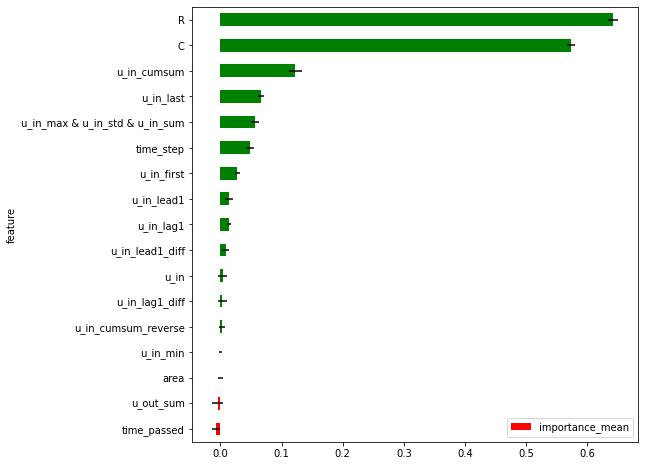

In [41]:
plot_importance(importance_df, figsize=(8, 8))